# Master DSLS / Programming 3 / Assignment 6
# Final Assignment

## Introduction
https://bioinf.nl/~martijn/master/programming3/assignment6.html

This is the final for programming 3. In this assignment, I will develop scikit-learn machine learning models to predict the function of the proteins in the specific dataset. This model will use small InterPro_annotations_accession to predict large InterPro_annotations_accession.
The definition of small InterPro_annotations_accession and large InterPro_annotations_accession is defined as below:

If InterPro_annotations_accession's feature length(Stop_location-Start_location) / Sequence_length > 0.9, it is large InterPro_annotations_accession.

Otherwise, it is a small InterPro_annotations_accession.

We can briefly rewrite as:

            |(Stop - Start)|/Sequence >  0.9 --> Large

            |(Stop - Start)|/Sequence <= 0.9 --> small

I will also check the "bias" and "noise" that does not make sense from the dataset.

ie. lines(-) from the TSV file which don't contain InterPRO numbers

ie. proteins which don't have a large feature (according to the criteria above)

## 1. Goal

The goal of this assignment is to predict large InterPro_annotations_accession by small InterPro_annotations_accession.

I will use the dataset from /data/dataprocessing/interproscan/all_bacilli.tsv file on assemblix2012 and assemblix2019. However, this file contains ~4,200,000 protein annotations, so I will put a subset of all_bacilli.tsv on GitHub and on local for code testing.

In [1]:
# Spark web UI:http://localhost:4040/jobs/
# Output format : https://interproscan-docs.readthedocs.io/en/latest/OutputFormats.html

# pyspark
import pyspark
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark_dist_explore import hist

# pyspark ML
from pyspark.ml.feature import StringIndexer,VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes, GBTClassifier, MultilayerPerceptronClassifier, LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 

# ETL & visualization
import numpy as np
import warnings
import time
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# call spark session
spsession = SparkContext('local[16]')


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/14 11:56:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
path= "/homes/dlsteur/Git_repos/Programming3/Assignment6/all_bacilli.tsv"


df = SQLContext(spsession).read.csv(path, sep=r'\t', header=None)#.select('col1','col2')
df=df.withColumnRenamed("_c1","Protein")\
   .withColumnRenamed("_c2","Sequence_MD5_digest")\
    .withColumnRenamed("_c3","Sequence_length")\
    .withColumnRenamed("_c4","Analysis")\
    .withColumnRenamed("_c5","Signature_accession")\
    .withColumnRenamed("_c6","Signature_description")\
    .withColumnRenamed("_c7","Start")\
    .withColumnRenamed("_c8","Stop")\
    .withColumnRenamed("_c9","Score")\
    .withColumnRenamed("_c10","Status")\
    .withColumnRenamed("_c11","Date")\
    .withColumnRenamed("_c12","Interpro_accession")\
    .withColumnRenamed("_c13","Interpro_description")\
    .withColumnRenamed("_c14","GO")\
    .withColumnRenamed("_c15","Pathway")
columns=df.columns   
df.limit(10).toPandas()
# remove column "_c0"
df=df.drop("_c0")

# remove InterPro_annotations_accession == "-"
# get the length of protein
df=df.withColumn("feature_Length", ((df['Stop']-df['Start'])))
# get the ratio to distinguish them to large and small InterPro_annotations_accession
df=df.withColumn("ratio", ((df['Stop']-df['Start'])/df['Sequence_length']))
# 1 for large, 0 for small InterPro_annotations_accession        
df=df.withColumn("Size", when((abs(df["Stop"] - df["Start"])/df["Sequence_length"])>0.9,1).otherwise(0))

to_drop=['Sequence_MD5_digest', 'Analysis',
       'Signature_accession', 'Signature_description', 
       'Score', 'Status', 'Date', 'Interpro_description',
       'GO', 'Pathway']
df=df.drop(*to_drop)
# sort on ration from big to small
df=df.sort(df.ratio.desc())
df.toPandas()

23/09/14 11:58:55 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


IllegalArgumentException: requirement failed: The number of columns doesn't match.
Old column names (16): _c0, _c1, _c2, _c3, _c4, _c5, _c6, _c7, _c8, _c9, _c10, _c11, _c12, _c13, _c14, _c15
New column names (15): Protein, Sequence_MD5_digest, Sequence_length, Analysis, Signature_accession, Signature_description, Start, Stop, Score, Status, Date, Interpro_accession, Interpro_description, GO, Pathway

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when

def process_protein_data(path):
    # Initialize SparkSession
    spark = SparkSession.builder.appName("ProteinDataProcessing").getOrCreate()

    # Read the data from the given path
    df = spark.read.csv(path, sep='\t', header=None)
    
    # Drop the first column "_c0"
    df = df.drop("_c0")

    # Rename columns
    df = df.toDF(
        "Protein", "Sequence_MD5_digest", "Sequence_length", "Analysis",
        "Signature_accession", "Signature_description", "Start", "Stop",
        "Score", "Status", "Date", "Interpro_accession",
        "Interpro_description", "GO", "Pathway"
    )

    # Remove rows where Interpro_accession == "-"
    df = df.filter(df["Interpro_accession"] != "-")

    # Calculate feature_Length
    df = df.withColumn("feature_Length", (df["Stop"] - df["Start"]))

    # Calculate the ratio
    df = df.withColumn("ratio", (df["feature_Length"] / df["Sequence_length"]))

    # Assign Size (1 for large, 0 for small)
    df = df.withColumn("Size", when(df["ratio"] > 0.9, 1).otherwise(0))

    # Select columns to drop
    to_drop = ["Sequence_MD5_digest", "Analysis", "Signature_accession", "Signature_description",
               "Score", "Status", "Date", "Interpro_description", "GO", "Pathway"]

    # Drop selected columns
    df = df.drop(*to_drop)

    # Sort by ratio from big to small
    df = df.orderBy(df.ratio.desc())

    return df

path = "/homes/dlsteur/Git_repos/Programming3/Assignment6/all_bacilli.tsv"
processed_df = process_protein_data(path)

# Show the processed DataFrame
processed_df.show()


+--------------------+---------------+-----+----+------------------+--------------+------------------+----+
|             Protein|Sequence_length|Start|Stop|Interpro_accession|feature_Length|             ratio|Size|
+--------------------+---------------+-----+----+------------------+--------------+------------------+----+
|gi|29896607|gb|AA...|            429|    1| 429|         IPR006264|         428.0|0.9976689976689976|   1|
|gi|29895450|gb|AA...|            419|    1| 419|         IPR016496|         418.0|0.9976133651551312|   1|
|gi|29894872|gb|AA...|            412|    1| 412|         IPR016039|         411.0|0.9975728155339806|   1|
|gi|29894872|gb|AA...|            412|    1| 412|         IPR017568|         411.0|0.9975728155339806|   1|
|gi|29897784|gb|AA...|            372|    1| 372|         IPR010162|         371.0|0.9973118279569892|   1|
|gi|29896081|gb|AA...|            350|    1| 350|         IPR024169|         349.0|0.9971428571428571|   1|
|gi|29895876|gb|AA...|      

In [9]:
# get the intersection to make sure there is a match of large and small InterPro_annotations_accession(at least one large and one small InterPro_annotations_accession)
intersection = processed_df.filter(processed_df.Size == 0).select("Protein").intersect(processed_df.filter(processed_df.Size == 1).select("Protein"))
intersection_df = intersection.join(processed_df,["Protein"])
# intersection_df.toPandas()

# select small proteins in df
small_proteins = processed_df.filter(processed_df.ratio < 0.9)

# select latrge proteins in df
large_proteins = processed_df.filter(processed_df.ratio >= 0.9)

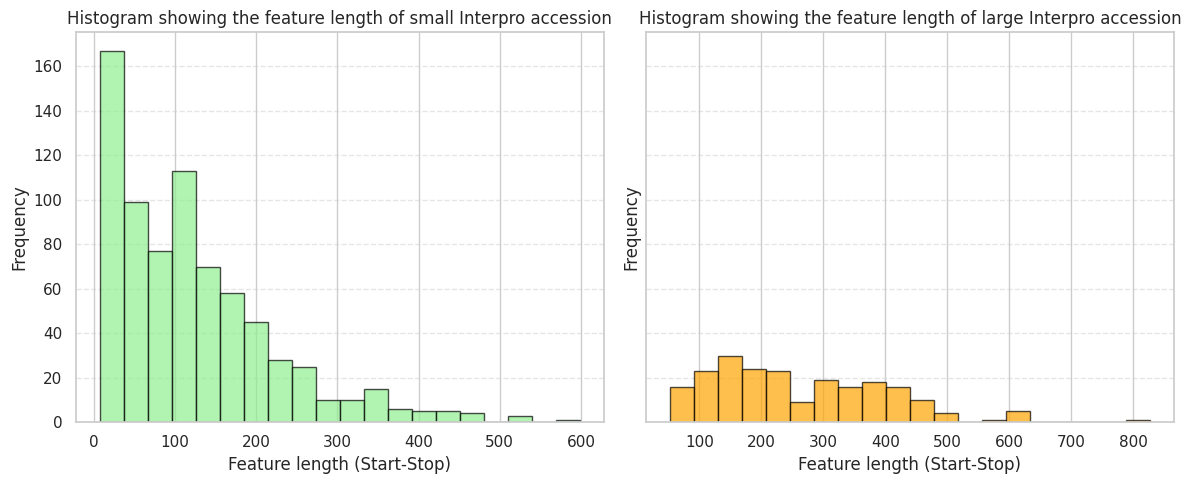

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a PySpark DataFrame named large_proteins and small_proteins
# Select the feature_Length column and convert it to a NumPy array
large_feature_lengths = large_proteins.select('feature_Length').rdd.flatMap(lambda x: x).collect()
small_feature_lengths = small_proteins.select('feature_Length').rdd.flatMap(lambda x: x).collect()

# Create subplots with a shared y-axis
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Customize the style of the histograms
color_large = 'orange'
color_small = 'lightgreen'
bins = 20

# Plot for large_proteins
axs[1].set_title('Histogram showing the feature length of large Interpro accession')
axs[1].set_xlabel('Feature length (Start-Stop)')
axs[1].set_ylabel('Frequency')
axs[1].hist(large_feature_lengths, bins=bins, color=color_large, edgecolor='black', alpha=0.7)

# Plot for small_proteins
axs[0].set_title('Histogram showing the feature length of small Interpro accession')
axs[0].set_xlabel('Feature length (Start-Stop)')
axs[0].set_ylabel('Frequency')
axs[0].hist(small_feature_lengths, bins=bins, color=color_small, edgecolor='black', alpha=0.7)

# Add gridlines
for ax in axs:
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Adjust spacing between subplots
plt.tight_layout()

plt.savefig('protein_histograms.png')

# Show the plot
plt.show()


/homes/dlsteur/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homes/dlsteur/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


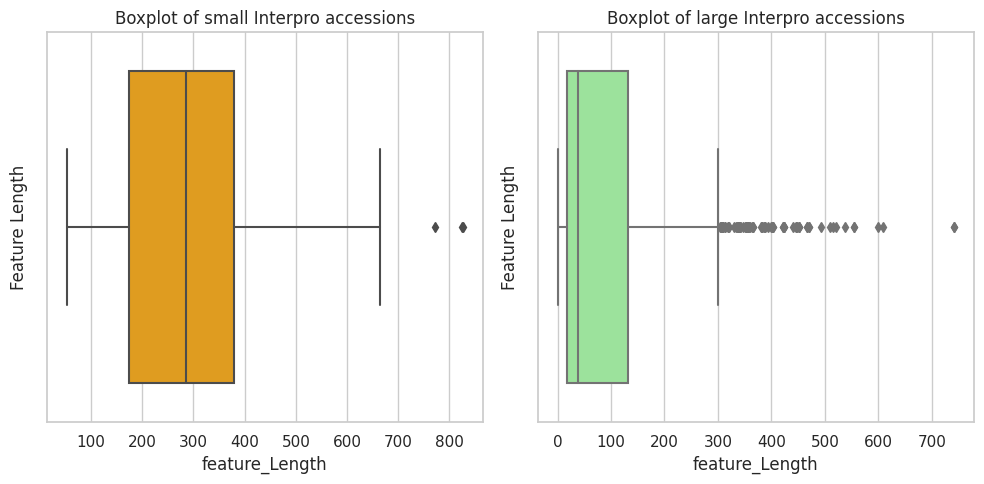

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have PySpark DataFrames large_proteins and small_proteins
# Convert the PySpark DataFrames to Pandas DataFrames
large_df = large_proteins.toPandas()
small_df = small_proteins.toPandas()

# Set Seaborn theme and style
sns.set_theme(style="whitegrid")

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot for small_proteins with light green color
sns.boxplot(x=small_df["feature_Length"], ax=axs[1], color='lightgreen')
axs[0].set_title('Boxplot of small Interpro accessions')
axs[0].set_ylabel('Feature Length')

# Plot for large_proteins with orange color
sns.boxplot(x=large_df["feature_Length"], ax=axs[0], color='orange')
axs[1].set_title('Boxplot of large Interpro accessions')
axs[1].set_ylabel('Feature Length')

# Adjust spacing between subplots
plt.tight_layout()

plt.savefig('protein_boxplot.png')

# Show the plot
plt.show()


In [11]:
# make a dataframe for ml
ml_df = intersection_df.select("Protein","feature_Length","ratio","Size")
ml_df.toPandas()

,Protein,feature_Length,ratio,Size
0,gi|29894058|gb|AAP07350.1|,230.0,0.987124,1
1,gi|29894058|gb|AAP07350.1|,99.0,0.424893,0
2,gi|29894058|gb|AAP07350.1|,76.0,0.326180,0
3,gi|29894058|gb|AAP07350.1|,76.0,0.326180,0
4,gi|29894058|gb|AAP07350.1|,87.0,0.373391,0
...,...,...,...,...
536,gi|29895753|gb|AAP09035.1|,387.0,0.962687,1
537,gi|29895753|gb|AAP09035.1|,143.0,0.355721,0
538,gi|29895753|gb|AAP09035.1|,391.0,0.972637,1
539,gi|29897231|gb|AAP10508.1|,313.0,0.857534,0


In [ ]:
# catalogize y variable
Label = StringIndexer(inputCol="InterPro_annotations_accession", outputCol="InterPro_index")

# catalogize X variable
input_columns = ML_df.columns[1:]
assembler = VectorAssembler(inputCols=input_columns,outputCol="InterPro_features")

pipeline = Pipeline(stages=[Label,assembler])
ML_final = pipeline.fit(ML_df).transform(ML_df)

# Setup X, y and split it
(trainData, testData) = ML_final.randomSplit([0.7, 0.3],seed=42)

In [ ]:
# save file
trainFile = '/students/2021-2022/master/DaanSteur_DSLS/trainData.pkl'
trainData.toPandas().set_index('InterPro_annotations_accession').to_pickle(trainFile)
testFile = '/students/2021-2022/master/DaanSteur_DSLS/testData.pkl'
testData.toPandas().set_index('InterPro_annotations_accession').to_pickle(testFile)

In [ ]:
# save model
nb_cvModel.bestModel.write().overwrite().save("/students/2021-2022/master/DaanSteur_DSLS/NaiveBayesBestModel")
dtc_cvModel.bestModel.write().overwrite().save("/students/2021-2022/master/DaanSteur_DSLS/DecisionTreeBestModel")
rf_cvModel.bestModel.write().overwrite().save("/students/2021-2022/master/DaanSteur_DSLS/RandomForestBestModel")